In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE


# Load the data
df = pd.read_csv('combined.csv')

In [2]:
# Strip any whitespace from column names
df.columns = df.columns.str.strip()

# Columns to remove, including IP addresses and ports which might not generalize well
columns_to_drop = ["flow ID", "source IP", "destination IP", "source port", "destination port", "date"]
df = df.drop(columns=columns_to_drop)

In [3]:
# Encoding categorical variables, including the 'Label' column
label_encoders = {}
categorical_columns = ['protocol', 'firstPacketDIR', 'mostCommonREQ_FUNC_CODE', 'mostCommonRESP_FUNC_CODE', 'Label']  # Include 'Label' as categorical
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [4]:
# Store the encoded labels separately and drop from dataframe
y = df['Label']
X = df.drop('Label', axis=1)

In [5]:
# Feature scaling
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()  # Only scale numerical columns
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

In [6]:
# Handling imbalanced dataset with SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)


In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)


In [8]:
# Model definitions with a simple hyperparameter grid
model_params = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 10]
        }
    }
}

In [9]:
# Training and evaluation with GridSearchCV
for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, scoring='accuracy', return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Best parameters for {model_name}: {clf.best_params_}")
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")

Best parameters for KNN: {'n_neighbors': 3}
Classification report for KNN:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     32590
           1       1.00      1.00      1.00     32681
           2       0.69      0.69      0.69     32310
           3       0.70      0.70      0.70     32706
           4       0.98      0.98      0.98     32617
           5       1.00      0.98      0.99     32661
           6       0.98      1.00      0.99     32516
           7       0.98      0.98      0.98     32701
           8       0.84      0.84      0.84     32514

    accuracy                           0.89    293296
   macro avg       0.89      0.89      0.89    293296
weighted avg       0.89      0.89      0.89    293296



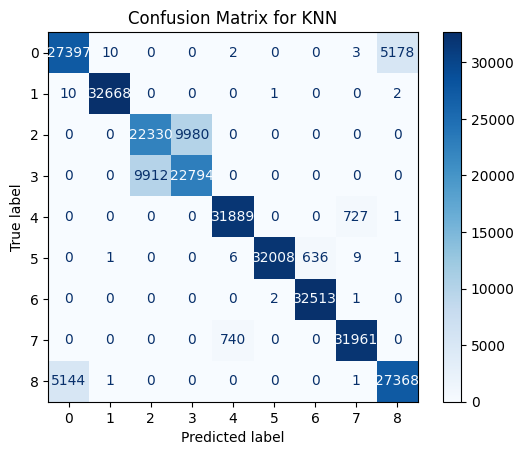

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for {model_name}")
plt.show()

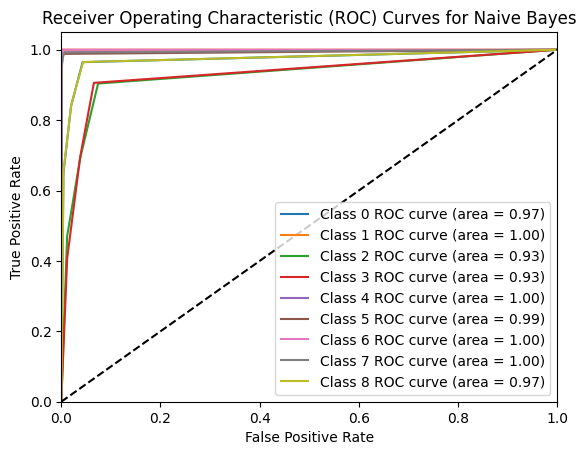

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Binarize the labels for multiclass classification
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Calculate the ROC curve and AUC for each class
for i in range(n_classes):
    y_proba = clf.predict_proba(X_test)[:, i]
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for Naive Bayes')
plt.legend(loc="lower right")
plt.show()